In [1]:
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

Using TensorFlow backend.


In [2]:

import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

%matplotlib inline

In [3]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report


In [25]:
import warnings
warnings.filterwarnings('ignore')

# Exploring the data

In [4]:
df = pd.read_csv("/home/ubuntu/Desktop/Internship/Precily/all_category_data_merged.csv")
df.head(10)

,text,category
0,"CALM MELODIES AND BEAUTIFUL PICTURES Debussy, ...",art
1,Skip the art museum and come experience “Great...,art
2,Buy “Art: Music & Painting - Van Gogh on on Ca...,art
3,"Thank you for listening, I hope you will have ...",art
4,NaN,art
5,When watching this special episode of The Perf...,art
6,Sanjeev Abhyankar and Rakesh Chaurasia rendere...,art
7,"Michelangelo with Mozart, Renoir with Chopin, ...",art
8,Visit: http://www.uctv.tv/) Join the Director ...,art
9,"Wishing you better sleep, peaceful meditations...",art


# Dealing with nan values

In [5]:
df['text']=df['text'].fillna("")

In [6]:
df['text'].apply(lambda x: len(x.split(' '))).sum()

290586

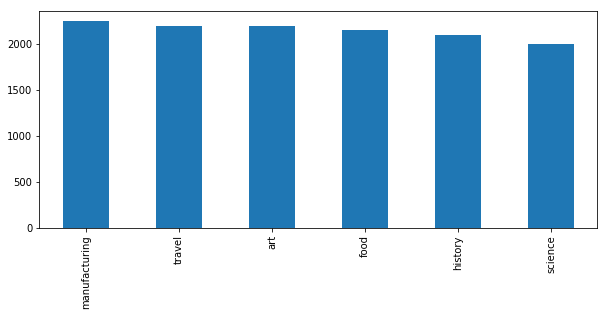

In [7]:
my_tags = ['food','manufacturing','science','travel','art','history']
plt.figure(figsize=(10,4))
df.category.value_counts().plot(kind='bar');

# Preprocessing Data

In [8]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [9]:
df['text'] = df['text'].apply(clean_text)

In [10]:
df['text'].apply(lambda x: len(x.split(' '))).sum()


184362

# Spliting Data

In [20]:
X = df.text
y = df.category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

# Function to plot Classification Report

In [12]:
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

y = np.random.randint(low=0, high=10, size=100)
y_p = np.random.randint(low=0, high=10, size=100)

def plot_classification_report(y_tru, y_prd, figsize=(10, 10), ax=None):

    plt.figure(figsize=figsize)

    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = list(np.unique(y_tru))
    yticks += ['avg']

    rep = np.array(precision_recall_fscore_support(y_tru, y_prd)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    sns.heatmap(rep,
                annot=True, 
                cbar=False, 
                xticklabels=xticks, 
                yticklabels=yticks,
                ax=ax)



# Logistic Regression 

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])

accuracy 0.9790697674418605
               precision    recall  f1-score   support

         food       1.00      0.98      0.99       651
manufacturing       1.00      0.98      0.99       672
      science       1.00      0.98      0.99       626
       travel       1.00      0.94      0.97       668
          art       0.89      1.00      0.94       615
      history       1.00      1.00      1.00       638

    micro avg       0.98      0.98      0.98      3870
    macro avg       0.98      0.98      0.98      3870
 weighted avg       0.98      0.98      0.98      3870

CPU times: user 100 ms, sys: 4 ms, total: 104 ms
Wall time: 102 ms


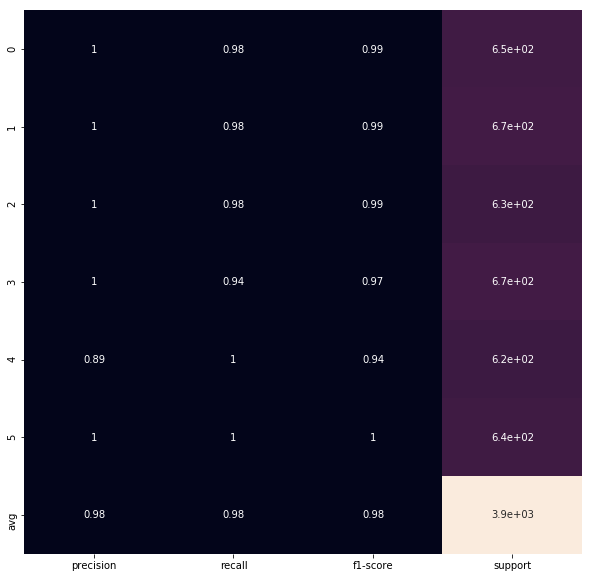

In [30]:
%%time

y_pred = logreg.predict(X_test)
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

plot_classification_report(y_test, y_pred)

# Bagging Model(Random Forest)

In [31]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier


rf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', (RandomForestClassifier(n_estimators=100))),
               ])
rf.fit(X_train, y_train)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

accuracy 0.9785529715762273
               precision    recall  f1-score   support

         food       1.00      0.98      0.99       651
manufacturing       1.00      0.98      0.99       672
      science       1.00      0.98      0.99       626
       travel       1.00      0.94      0.97       668
          art       0.89      0.99      0.94       615
      history       0.99      1.00      1.00       638

    micro avg       0.98      0.98      0.98      3870
    macro avg       0.98      0.98      0.98      3870
 weighted avg       0.98      0.98      0.98      3870

CPU times: user 232 ms, sys: 0 ns, total: 232 ms
Wall time: 409 ms


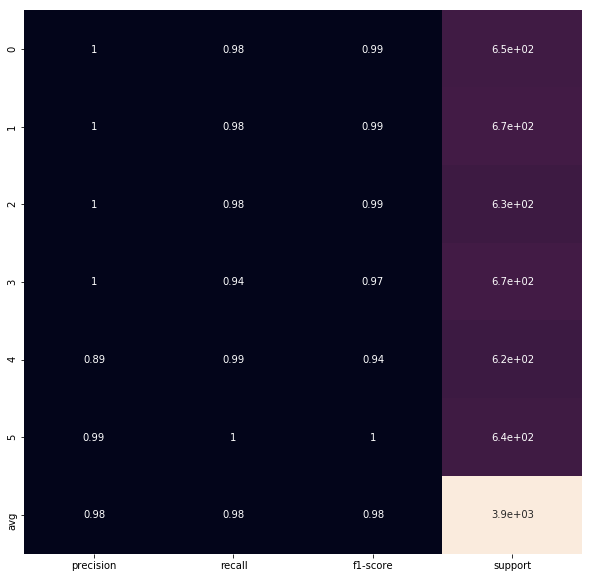

In [32]:
%%time

y_pred = rf.predict(X_test)
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

plot_classification_report(y_test, y_pred)

In [13]:
import numpy

# Word Embeddings

In [14]:
# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('/home/ubuntu/Desktop/Internship/Intellify/wiki-news-300d-1M.vec')):
    values = line.split()
    embeddings_index[values[0]] = numpy.asarray(values[1:], dtype='float32')

In [15]:
# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(df['text'])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(X_train), maxlen=70)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(X_test), maxlen=70)

# create token-embedding mapping
embedding_matrix = numpy.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Converting Categorical data to numerical

In [17]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df.category = lb_make.fit_transform(df.category)



# Model Building
The following function is a utility function which can be used to train a model. It accepts the classifier, feature_vector of training data, labels of training data and feature vectors of valid data as inputs. Using these inputs, the model is trained and accuracy score is computed.



In [18]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    print(classification_report(y_test, predictions,target_names=my_tags))
    plot_classification_report(y_test, predictions)
    return metrics.accuracy_score(predictions, y_test)


#  Bidirectional RNN
RNN layers can be wrapped in Bidirectional layers as well

Epoch 1/1
9030/9030 [==============================] - 27s 3ms/step - loss: -22.1697
               precision    recall  f1-score   support

         food       0.17      1.00      0.29       651
manufacturing       0.00      0.00      0.00       672
      science       0.00      0.00      0.00       626
       travel       0.00      0.00      0.00       668
          art       0.00      0.00      0.00       615
      history       0.00      0.00      0.00       638

    micro avg       0.17      0.17      0.17      3870
    macro avg       0.03      0.17      0.05      3870
 weighted avg       0.03      0.17      0.05      3870

RNN-Bidirectional, Word Embeddings 0.1682170542635659


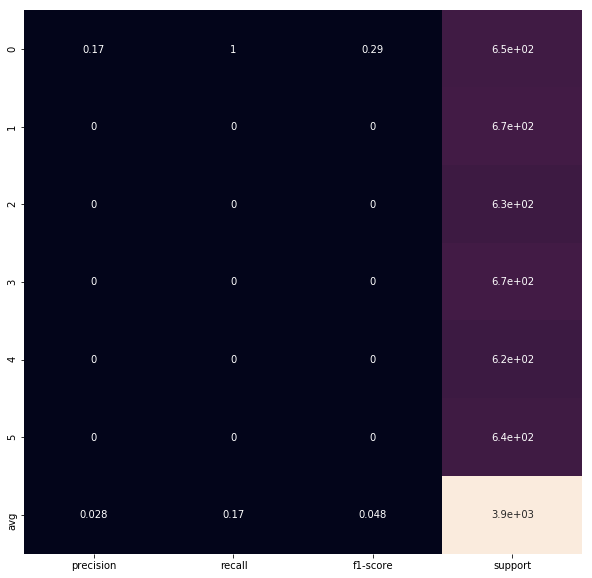

In [28]:
def create_bidirectional_rnn():
      # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.Bidirectional(layers.GRU(100))(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_bidirectional_rnn()
accuracy = train_model(classifier, train_seq_x, y_train, valid_seq_x, is_neural_net=True)
print ("RNN-Bidirectional, Word Embeddings",  accuracy)

# Convolutional Neural Network

Epoch 1/1
9030/9030 [==============================] - 9s 990us/step - loss: -20.8983
               precision    recall  f1-score   support

         food       0.17      1.00      0.29       651
manufacturing       0.00      0.00      0.00       672
      science       0.00      0.00      0.00       626
       travel       0.00      0.00      0.00       668
          art       0.00      0.00      0.00       615
      history       0.00      0.00      0.00       638

    micro avg       0.17      0.17      0.17      3870
    macro avg       0.03      0.17      0.05      3870
 weighted avg       0.03      0.17      0.05      3870

CNN, Word Embeddings 0.1682170542635659


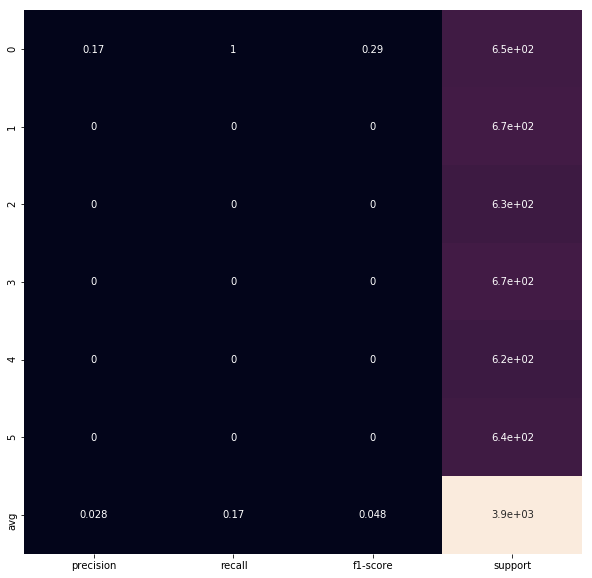

In [27]:
def create_cnn():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_cnn()
accuracy = train_model(classifier, train_seq_x, y_train, valid_seq_x, is_neural_net=True)
print ("CNN, Word Embeddings",  accuracy)